# Fast LLM from Scratch

# demo.ipynb

In [6]:
import torch
from PIL import Image
from transformers import AutoTokenizer, AutoModelForCausalLM
import sys
from pathlib import Path

# --- 1. 设置设备和模型路径 (Mac 优化) ---
# 检查是否有可用的 MPS (Apple Silicon GPU) 后端
if torch.backends.mps.is_available():
    device = "mps"
    torch_dtype = torch.float16 # MPS 支持 float16
elif torch.backends.cuda.is_available():
    device = "cuda"
    torch_dtype = torch.float16 # CUDA 支持 float16
else:
    device = "cpu"
    torch_dtype = torch.float32

model_path = "./checkpoints/FastVLM-1.5B"


print(f"Using device: {device}")
print(f"Loading model from: {model_path}")

# --- 2. 加载 Tokenizer 和模型 ---
tok = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
# 移除 device_map="auto"，并在加载后手动将模型移动到设备
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    dtype=torch_dtype,
    trust_remote_code=True,
).to(device)

# --- 3. 准备输入：文本和图像 ---
messages = [
    {"role": "user", "content": "<image>\n describe the image."}
]
rendered = tok.apply_chat_template(
    messages, add_generation_prompt=True, tokenize=False
)

image_path = "examples/lake.jpg"
try:
    img = Image.open(image_path).convert("RGB")
    print(f"Successfully loaded image from: {image_path}")
except FileNotFoundError:
    print(f"Error: Image not found at {image_path}.")
    img = None

if img:
    # --- 4. 准备模型输入 ---
    pixel_values = model.get_vision_tower().image_processor(images=img, return_tensors="pt")["pixel_values"]
    pixel_values = pixel_values.to(device, dtype=torch_dtype)

    IMAGE_TOKEN_INDEX = -200
    pre_text, post_text = rendered.split("<image>", 1)
    
    pre_ids  = tok(pre_text,  return_tensors="pt", add_special_tokens=False).input_ids
    post_ids = tok(post_text, return_tensors="pt", add_special_tokens=False).input_ids
    
    image_token_tensor = torch.tensor([[IMAGE_TOKEN_INDEX]], dtype=pre_ids.dtype)
    
    # 确保所有张量都在正确的设备上
    input_ids = torch.cat([pre_ids, image_token_tensor, post_ids], dim=1).to(device)
    attention_mask = torch.ones_like(input_ids, device=device)

    # --- 5. 运行模型生成 ---
    with torch.no_grad():
        generate_ids = model.generate(
            inputs=input_ids,
            attention_mask=attention_mask,
            images=pixel_values,
            max_new_tokens=128,
            do_sample=False,
        )

    # --- 6. 解码并打印结果 ---
    print(tok.decode(generate_ids[0], skip_special_tokens=True))

    
    

Using device: mps
Loading model from: ./checkpoints/FastVLM-1.5B
Successfully loaded image from: examples/lake.jpg
The image depicts a serene lakeside scene with a wooden dock extending into the calm, expansive water. The dock, constructed from wooden planks, features a ladder on its right side, suggesting it is used for swimming or boarding boats. The water is remarkably still, with only slight ripples disturbing its surface, indicating a tranquil environment. The sky above is overcast, with a uniform gray hue that suggests an impending rain or a recent rainfall. In the distance, the horizon is faintly visible, blending the water and sky into a seamless expanse. The overall atmosphere of the image is calm and peaceful, with no signs of human activity


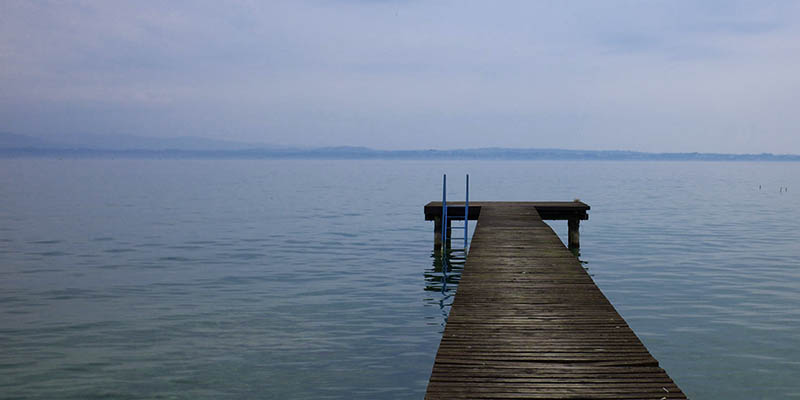

In [7]:
# --- 7. 图片 ---
img